<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/NorthwesternHeader.png?raw=1">

Yining Feng

MSDS 453 Natural Language Processing <br>
Movie Review Classification <br>
Due: 3/17/2021 <br>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Instructions to run this notebook:
Copy the contents of the shared drive to your google drive and ensure that the path of the MSDS453 folder matches to the path below. Once you do that you should be able to run the notebook.

The notebook refrences the models as well as the week5 sentiment polarity dataset

In [ ]:
! pip install spacy==2.2.2
! pip install stanfordnlp==0.2.0
! pip install networkx==2.3

     |████████████████████████████████| 10.3MB 8.3MB/s 
     |████████████████████████████████| 2.2MB 31.7MB/s 
  Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Found existing installation: spacy 2.2.4
    Uninstalling spacy-2.2.4:
      Successfully uninstalled spacy-2.2.4
     |████████████████████████████████| 163kB 9.3MB/s 
     |████████████████████████████████| 1.8MB 7.5MB/s 
  Created wheel for networkx: filename=networkx-2.3-py2.py3-none-any.whl size=1556408 sha256=3867a3e656c11af21799752b5652570d3e98269d21a39e338c2c95cf025dc1c9
  Stored in directory: /root/.cache/pip/wheels/de/63/64/3699be2a9d0ccdb37c7f16329acf3863fd76eda58c39c737af
Successfully built networkx
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: networkx 2.5
    Uninstalling networkx-2.5:
      Successfully uninstalled networkx-2.5


In [ ]:
###############################################################################
### packages required to run code.  Make sure to install all required packages.
###############################################################################
#  general
import matplotlib.pyplot as plt
import pandas as pd
import os
import string
import numpy as np
import re
import pickle
import warnings


# sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_files
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix


# nltk
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

import spacy as spacy
nlp = spacy.load("en_core_web_sm")

In [ ]:
if 'google.colab' in str(get_ipython()):
    rootpath = "/content/drive/MyDrive"  
else:
    rootpath = "g:/My Drive"  

asg = "/movie_reviews/"

filepath = rootpath + asg
logspath = rootpath + "logs/" + asg
modelspath = filepath + "models/"
objpath = filepath + "objects/"
outputpath = filepath + "output/"

In [ ]:
warnings.filterwarnings('ignore')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
#Section 3, 4, 5: Classifiers
def sklearn_classifiers(X_train, X_test, y_train, y_test, model_type):
    
    #this function is to fit 3 different model scenarios.  Support vector machines, logistic regressions, naive bayes.
    #svm = Support vector machin
    #logistic = Logistic regression
    #naive_bayes = Naive Bayes Multinomial
    
 
    #function returns the train test split scores of each model.
    
    if model_type == 'svm':
        print("svm")
        model = SVC()

    elif model_type == 'logistic':
        print("logistic")
        model = LogisticRegression()

    elif model_type == 'naive_bayes':
        print("naive_bayes")
        model = MultinomialNB() 
    
    model.fit(X_train, y_train)

    
    #NOTE THIS IS AN OVERFIT CASE SO YOU KNOW THAT IT IS WORKING
    #ONCE YOU GET CLOSE TO 100% ACCURACY THEN COMMENT OUT THESE TWO LINES
    #predictions = model.predict(X_train)
    #accy = accuracy_score(y_train, predictions)
    
    #NOTE THIS IS THE CORRECT WAY TO TEST YOUR CLASSIFIERS
    #UNCOMMENT THESE TWO LINES ONCE THE OVERFIT CASE YIELDS CLOSE TO 100% ACCURACY
    predictions = model.predict(X_test)
    accy = accuracy_score(y_test, predictions)
    
    return model, predictions, accy

In [ ]:
def process_text(X, min_df=5, bigrams=False):
    documents = []
    from nltk.stem import WordNetLemmatizer

    stemmer = WordNetLemmatizer()

    for sen in range(0, len(X)):
        # Remove all the special characters
        document = re.sub(r'\W', ' ', str(X[sen]))
        
        # remove all single characters
        document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
        
        # Remove single characters from the start
        #document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
        
        # Substituting multiple spaces with single space
        document = re.sub(r'\s+', ' ', document, flags=re.I)
        
        # Removing prefixed 'b'
        document = re.sub(r'^b\s+', '', document)
        
        # Converting to Lowercase
        document = document.lower()
        
        # Lemmatization
        document = document.split()

        document = [stemmer.lemmatize(word) for word in document]
        document = ' '.join(document)
        
        documents.append(document)

    if bigrams==True:
            tfidfconverter = TfidfVectorizer(max_features=1500, min_df=min_df, ngram_range=(1,2), max_df=0.7, stop_words=stopwords.words('english'))
    else:
            tfidfconverter = TfidfVectorizer(max_features=1500, min_df=min_df, max_df=0.7, stop_words=stopwords.words('english'))


    X = tfidfconverter.fit_transform(documents).toarray()
    words = tfidfconverter.get_feature_names()
    return X, documents, words

In [ ]:
def most_informative_feature_for_binary_classification(feature_names, classifier, n=10):
    class_labels = classifier.classes_
    #feature_names = vectorizer.get_feature_names()
    topn_class1 = sorted(zip(classifier.coef_[0], feature_names))[:n]
    topn_class2 = sorted(zip(classifier.coef_[0], feature_names))[-n:]

    for coef, feat in topn_class1:
        print (class_labels[0], coef, feat)

    print()

    for coef, feat in reversed(topn_class2):
        print (class_labels[1], coef, feat)

def most_informative_feature_for_classification(classifier, document, n=10):

    return words 

In [ ]:
# function to get dictionary of features for nltk classifiers
def get_feature(r):
    feature = {}
    #print(r.shape)
    for i, value in enumerate(r):
        #print(i)
        feature[words[i]] = value
    return feature

## Load Corpus

### load NLTK polarity data set

In [ ]:
dir='/content/drive/MyDrive/txt_sentoken/'

movie_data = load_files(dir)
X, y = movie_data.data, movie_data.target
X, documents, words = process_text(X,  min_df=2, bigrams=True)
class_names=set(y)

In [ ]:
X.shape, len(documents), len(words)

((2000, 1500), 2000, 1500)

In [ ]:
df = pd.DataFrame(movie_data.data, columns=['text'])
df['text'] = df['text'].str.decode('utf-8')


### Some stats about the data

In [ ]:
tokens = df['text'].str.split()
# total number of tokens
token_count = sum([len(l) for l in tokens])
token_count

1492681

In [ ]:
all_tokens = []
for l in tokens:
    all_tokens = all_tokens + l

In [ ]:
 series = pd.DataFrame(data=all_tokens).value_counts()
 series.head(10)

,      77717
the    76178
.      65876
a      37934
and    35343
of     33970
to     31759
is     25163
in     21591
"      17612
dtype: int64

In [ ]:
len(series)

50920

In [ ]:
token_count = sum([len(l) for l in tokens])
token_count

1492681

In [ ]:
df = pd.DataFrame(data=X)
df.columns = words
tf_idf_corpus = df

In [ ]:
# ensure this word is not already in the columns
'NLTKfeatures' in tf_idf_corpus.columns

False

In [ ]:
tf_idf_corpus['NLTKfeatures'] = tf_idf_corpus.apply(get_feature, axis=1)

## SKlearn Classifiers

In [ ]:
# split the training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
print(len(X))
print(len(y))

2000
2000


In [ ]:
model_svm, y_hat, accy = sklearn_classifiers(X_train, X_test, y_train, y_test,'svm')
accy

svm


0.8212121212121212

In [ ]:
def display_confusion_matrix(classifier, X_test, y_test, y_hat,class_names ):
    cm=confusion_matrix(y_test, y_hat)
    np.set_printoptions(precision=2)

    titles_options = [("Confusion matrix, without normalization", None),
                        ("Normalized confusion matrix", 'true')]
    for title, normalize in titles_options:
            disp = plot_confusion_matrix(classifier, X_test, y_test,
                                        display_labels=class_names,
                                        cmap=plt.cm.Blues,
                                        normalize=normalize)
            disp.ax_.set_title(title)
            print(title)
            print(disp.confusion_matrix)

    plt.show()


In [ ]:
def model_metrics(y_test, y_hat):
    # Actual = 0 (negative), but predicted = 1 (positive)
    false_positive = np.where((y_test != y_hat) & (y_test ==0))
    print(f'False Positive  count = {len(false_positive[0])}\n {false_positive} \n')

    # Actual = 1 (positive), but predicted = 0 (negative)
    false_negative = np.where((y_test != y_hat) & (y_test ==1))
    print(f'False Negative  count = {len(false_negative[0])}\n {false_negative}')


Confusion matrix, without normalization
[[265  54]
 [ 64 277]]
Normalized confusion matrix
[[0.83 0.17]
 [0.19 0.81]]


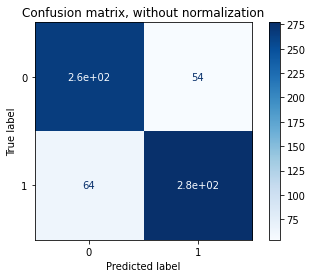

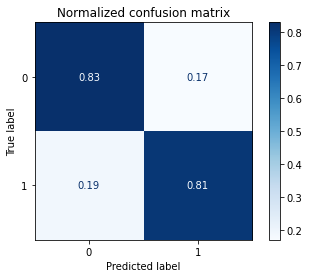

In [ ]:
display_confusion_matrix(model_svm, X_test, y_test, y_hat, class_names)

In [ ]:
model_metrics(y_test, y_hat)

False Positive  count = 54
 (array([  1,  10,  12,  17,  26,  37,  80,  89, 109, 122, 139, 141, 160,
       164, 171, 173, 177, 178, 198, 238, 258, 278, 293, 296, 310, 313,
       322, 323, 325, 342, 349, 354, 360, 381, 389, 402, 405, 406, 414,
       424, 458, 465, 474, 475, 494, 520, 530, 553, 585, 594, 596, 603,
       640, 643]),) 

False Negative  count = 64
 (array([  0,  16,  38,  64,  67,  75,  81,  83, 107, 108, 132, 169, 170,
       185, 189, 190, 215, 255, 267, 269, 270, 283, 291, 303, 308, 311,
       312, 331, 344, 358, 359, 362, 370, 399, 420, 428, 431, 436, 437,
       447, 449, 452, 455, 481, 485, 492, 506, 508, 515, 531, 550, 559,
       571, 572, 575, 590, 599, 611, 615, 620, 624, 635, 639, 650]),)


In [ ]:
txt_lookup={}
for i in range(0,len(documents)):
    txt_lookup[str(X[i])]=documents[i]
#creating datafram from TFIDF Matrix
print(txt_lookup[str(X_test[0])])

apollo 13 is simply one of the most dramatic film this summer apart from swashbuckling braveheart ndirector and former actor ron howard splash backdraft far away most noted for his dramatic film making display again his brilliance in creating drama and suspense in apollo 13 nbeing the second largest box office hit in the u this summer with more than u 150 million in the state alone this film is his most successful effort yet nperhaps one of the most appealing feature of this film is the pool of talented actor such a tom hank gump himself kevin bacon footloose tremor few good men etc gary sinise forrest gump bill paxton alien true lie boxing helena and ed harris the abyss just cause nall of whom gave good performance in their respective role napollo 13 wa the second worst accident ever to occur in the history of u spaceflight the worst being the challenger accident njim lovell hank the mission commander together with his crew fred haise paxton and last minute replacement tom swigert bac

In [ ]:
from nltk.metrics import precision,recall,f_measure
import collections

# defaultdict works like a python dict but also adds the key if it does not exist
refsets = collections.defaultdict(set)
testsets = collections.defaultdict(set)

# create a dictionary that has the index of all positive and negative documents
# refsets is the actual class and testset is the predicted class 
for i, label in enumerate(y_test):
    refsets[label].add(i)
    observed = y_hat[i]
    testsets[observed].add(i)

# Uses sets to compute precision and recall
# precision = (refrence ∩ test)/ test
# recall = (reference ∩ test) / reference
#print(refsets)
print('pos precision:', precision(refsets[1], testsets[1]))
print( 'pos recall:', recall(refsets[1], testsets[1]))
print('pos F-measure:', f_measure(refsets[1], testsets[1]))
print('neg precision:', precision(refsets[0], testsets[0]))
print('neg recall:', recall(refsets[0], testsets[0]))
print('neg F-measure:', f_measure(refsets[0], testsets[0]))

pos precision: 0.8368580060422961
pos recall: 0.8123167155425219
pos F-measure: 0.824404761904762
neg precision: 0.8054711246200608
neg recall: 0.8307210031347962
neg F-measure: 0.8179012345679013


In [ ]:
modelfile = modelspath + 'model_svm_pol.pickle'
with open(modelfile, mode='wb') as outfile:
    pickle.dump(model_svm, outfile )


In [ ]:
model_logit, y_hat, accy = sklearn_classifiers(X_train, X_test, y_train, y_test,'logistic')
accy

logistic


0.8151515151515152

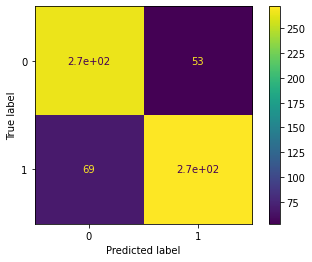

In [ ]:
plot_confusion_matrix(model_logit, X_test, y_test)  
plt.show()

In [ ]:
modelfile = modelspath + 'model_logit_pol.pickle'
with open(modelfile, mode='wb') as outfile:
    pickle.dump(model_logit, outfile )

In [ ]:
most_informative_feature_for_binary_classification(words, model_logit, n=10)

0 -3.0183795080166216 bad
0 -2.0535014499136786 worst
0 -2.046719588144786 plot
0 -1.7501465911675431 supposed
0 -1.635241693894532 script
0 -1.5232536709383573 boring
0 -1.5025787813439366 nothing
0 -1.480090795897062 attempt
0 -1.3054437283151408 stupid
0 -1.3004882089024818 awful

1 2.006509473214591 well
1 1.8109590397196704 great
1 1.7475755603409453 life
1 1.6178856619087232 also
1 1.489546795673507 war
1 1.4402539380782797 performance
1 1.3810217210013598 best
1 1.218634232738987 political
1 1.166735768139537 perfectly
1 1.1381097136937846 fun


In [ ]:
logit_coef = sorted(zip(model_logit.coef_[0], words), reverse=True)
df = pd.DataFrame(logit_coef, columns=['coef', 'word'])
logit_coef_df = df
logit_coef_df.to_pickle(objpath + 'polarity_logit_coef.pickle' )


In [ ]:
df = pd.DataFrame(logit_coef, columns=['coef', 'word'])

In [ ]:
model_nb, predictions, accy = sklearn_classifiers(X_train, X_test, y_train, y_test,'naive_bayes')
accy

naive_bayes


0.793939393939394

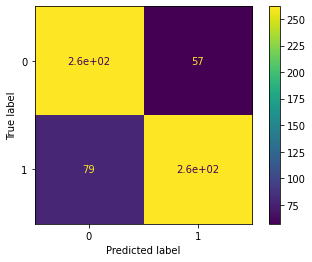

In [ ]:
plot_confusion_matrix(model_nb, X_test, y_test)  
plt.show()

In [ ]:
modelfile = modelspath + 'model_naive_bayes_pol.pickle'
with open(modelfile, mode='wb') as outfile:
    pickle.dump(model_nb, outfile )

In [ ]:
most_informative_feature_for_binary_classification(words, model_nb, n=10)

0 -8.882146507424094 godzilla
0 -8.614468097674749 ridiculous
0 -8.555418241726386 awful
0 -8.548564315138002 wasted
0 -8.529759660606565 poorly
0 -8.528497912954247 specie
0 -8.4775366320544 lame
0 -8.45113782217761 bad movie
0 -8.434951517177524 waste
0 -8.409256199256486 pointless

1 -5.8361651166986 life
1 -5.836474290470502 story
1 -5.846104341301183 nit
1 -5.90393283616781 scene
1 -5.970660258308742 good
1 -5.9808570585419325 get
1 -5.994254350316394 make
1 -6.004413973339101 well
1 -6.011321595638762 also
1 -6.053388884248683 nhe


## NLTK Clasifiers

In [ ]:
featuresets = [(f, y[i]) for i, f in enumerate (tf_idf_corpus['NLTKfeatures'])]

In [ ]:
training_set = featuresets[:1900]
testing_set = featuresets[1900:]

In [ ]:
classifier = nltk.NaiveBayesClassifier.train(training_set)

In [ ]:
print("Naive bayes algo accurcy:", (nltk.classify.accuracy(classifier, testing_set))*100)

Naive bayes algo accurcy: 60.0


In [ ]:
classifier.show_most_informative_features(15)

Most Informative Features
                     bad = 0.0                 1 : 0      =      1.5 : 1.0
             performance = 0.0                 0 : 1      =      1.3 : 1.0
                    plot = 0.0                 1 : 0      =      1.3 : 1.0
                    life = 0.0                 0 : 1      =      1.3 : 1.0
                    well = 0.0                 0 : 1      =      1.3 : 1.0
                      ni = 0.0                 1 : 0      =      1.3 : 1.0
                    also = 0.0                 0 : 1      =      1.3 : 1.0
                    best = 0.0                 0 : 1      =      1.2 : 1.0
                     see = 0.0                 0 : 1      =      1.2 : 1.0
                   world = 0.0                 0 : 1      =      1.2 : 1.0
                   great = 0.0                 0 : 1      =      1.2 : 1.0
                   worst = 0.0                 1 : 0      =      1.2 : 1.0
                  script = 0.0                 1 : 0      =      1.2 : 1.0

## Class Corpus sentiment


### Load Class Corpus

In [ ]:
#load class corpus
path_to_file= filepath + '2021_Winter_453_Sec56_Class_Corpus_Updated.csv'
data=pd.read_csv(path_to_file)
title = data['DSI_Title']
text = list(data['Text'])

In [ ]:
X_class_corpus, documents_class_corpus, features_class_corpus = process_text(text, min_df=2)

In [ ]:
data['svm'] = model_svm.predict(X_class_corpus)
data['logit'] = model_logit.predict(X_class_corpus)
data['naive_bayes'] = model_nb.predict(X_class_corpus)

In [ ]:
# 0 is negative and 1 is positive
data[['DSI_Title', 'svm', 'logit', 'naive_bayes']]


,DSI_Title,svm,logit,naive_bayes
0,KS_Doc1_2001 Space Odyssey.txt,1,1,0
1,KS_Doc2_Wargames.txt,1,1,1
2,KS_Doc3_The_Matrix.txt,0,0,0
3,KS_Doc4_I_Robot.txt,1,1,1
4,KS_Doc5_Ex_Machina.txt,1,1,1
5,KS_Doc6_Her.txt,0,0,1
6,KS_Doc7_The Terminator.txt,1,1,1
7,PP_Doc1_Disneys_New_Mulan.txt,0,0,0
8,PP_Doc2_Cinderella_Review_Straight-Faced.txt,0,0,0
9,PP_Doc3_Aladdin_Review_This.txt,1,1,1


## Determine key words based on the above predictors 

## Based on above models create labeled Data set for the class corpus. 

In [ ]:
y_class_corpus = data['logit'].to_numpy()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_class_corpus, y_class_corpus, test_size=0.2, random_state=0)

In [ ]:
X_train.shape,X_test.shape

((33, 1500), (9, 1500))

In [ ]:
model_svm, y_hat, accy = sklearn_classifiers(X_train, X_test, y_train, y_test ,'svm')
accy

svm


0.7777777777777778

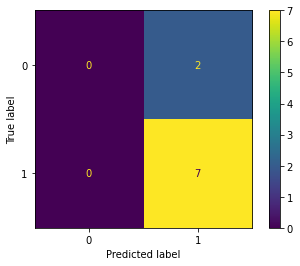

In [ ]:
plot_confusion_matrix(model_svm, X_test, y_test)  
plt.show()

In [ ]:
model_logit, y_hat, accy = sklearn_classifiers(X_train, X_test, y_train, y_test ,'logistic')
accy

logistic


0.7777777777777778

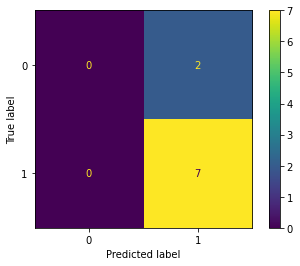

In [ ]:
plot_confusion_matrix(model_logit, X_test, y_test)  
plt.show()

In [ ]:
most_informative_feature_for_binary_classification(features_class_corpus, model_logit, n=10)

0 -0.5211564510807193 ford
0 -0.3054758218366443 india
0 -0.29336977199480013 washington
0 -0.2872924321666823 red
0 -0.2867816142734053 october
0 -0.28377182298426995 cia
0 -0.25985653269186404 captain
0 -0.2292294671447466 hunt
0 -0.2148227104866178 reality
0 -0.19359641086174778 stone

1 0.32185422396058794 robot
1 0.2872134520045908 site
1 0.28403099912558794 link
1 0.28403099912558794 external
1 0.24675042720393647 paris
1 0.22689249845734125 carter
1 0.1826594219883004 alice
1 0.17516668014118905 turing
1 0.16922309441269323 jungle
1 0.16549873534707424 story


In [ ]:
model_nb, predictions, accy = sklearn_classifiers(X_train, X_test, y_train, y_test ,'naive_bayes')
accy

naive_bayes


0.7777777777777778

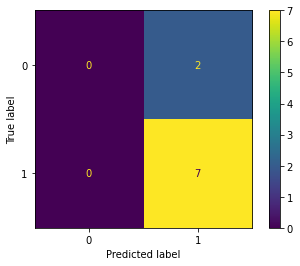

In [ ]:
plot_confusion_matrix(model_nb, X_test, y_test)  
plt.show()

In [ ]:
most_informative_feature_for_binary_classification(features_class_corpus, model_nb, n=10)

0 -7.428097788563016 13
0 -7.428097788563016 2007
0 -7.428097788563016 5th
0 -7.428097788563016 ability
0 -7.428097788563016 aboard
0 -7.428097788563016 accepted
0 -7.428097788563016 across
0 -7.428097788563016 acting
0 -7.428097788563016 added
0 -7.428097788563016 admirer

1 -6.5171862480021145 link
1 -6.5171862480021145 external
1 -6.524509654337906 site
1 -6.747122323016045 robot
1 -6.821523969527449 wa
1 -6.846271008073575 computer
1 -6.848705931524994 story
1 -6.876605386285523 paris
1 -6.87793208789448 disney
1 -6.930302336931296 man
